# Random Forest

This notebook uses a **Random Forest** classifier, a discriminative model, to solve the classification task of digits labeling.

## Packages import

In [1]:
from sklearn.model_selection import train_test_split

from assignment_2.digits_classifiers.model import Dataset, ClassifierTuning
from assignment_2.digits_classifiers.classifiers import RandomForest
from assignment_2.digits_classifiers.io import read_datasets
from assignment_2.digits_classifiers.utils import chunks, plot_digit

## Import dataset

Reading [MNIST handwritten digits]((https://yann.lecun.com/exdb/mnist/)) dataset.

In [2]:
data = read_datasets()

2022-12-26 15:22:30.439 | INFO     | assignment_2.digits_classifiers.io:read_datasets:46 - Reading datasets


In [3]:
X, y = data

## Train Test split

Splitting train and test set with **proportion 4:1**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

Combining feature space and labels

In [5]:
train = Dataset(x=X_train, y=y_train)
test = Dataset(x=X_test, y=y_test)

Digit distribution in the training set:

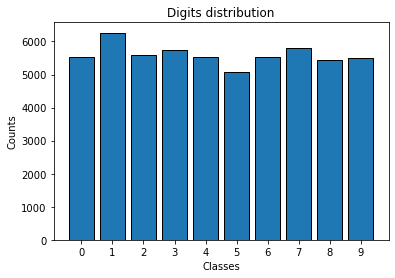

In [6]:
train.digit_distribution()

## Experimental Evaluation

### Validation Phase

Generating classifiers with candidate hyperparameters

In [7]:
forests = [
    RandomForest(train=train, test=test, params={"n_estimators": ne, "max_depth": md})
    for ne in [100, 1000, 3000]
    for md in [100, 300, 500]
]
forests

[[RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 100; Max-depth: 100],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 100; Max-depth: 300],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 100; Max-depth: 500],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 1000; Max-depth: 100],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 1000; Max-depth: 300],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 1000; Max-depth: 500],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 3000; Max-depth: 100],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 3000; Max-depth: 300],
 [RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 3000; Max-depth: 500]]

Restricting Train set cardinality for validation phase to 50%

In [8]:
_, X_train_cv, _, y_train_cv = train_test_split(X_train, y_train, test_size=0.50)
train_cv = Dataset(x=X_train_cv, y=y_train_cv)

In [9]:
X_train_cv.shape

(28000, 784)

Generating tuning class

In [11]:
tuning_forest = ClassifierTuning(classifiers=forests, base_estimator=RandomForest.default_estimator(), data=train_cv, k=10)
tuning_forest

[Estimator: RandomForestClassifier(); K: 10; Params: {'n_estimators': [1000, 100, 3000], 'max_depth': [100, 500, 300]}]

Evaluating 10-fold Cross-Validation

In [12]:
%%time
tuning_forest.evaluate()

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.96385714 0.96025    0.96382143 0.96303571 0.96003571        nan
 0.96435714 0.95989286 0.96414286]
  warnings.warn(


Wall time: 1h 30min 28s


Selected model with 1000 trees and a maximum depth of 300:

In [13]:
tuning_forest.best_params

{'max_depth': 300, 'n_estimators': 1000}

Accuracy of the selected model:

In [14]:
tuning_forest.best_score

0.9643571428571429

### Training phase

Generating the model with tuned hyperparameters

In [15]:
best_forest = RandomForest(train=train, test=test, params={'n_estimators': 1000, 'max_depth': 100})
best_forest

[RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 1000; Max-depth: 100]

Training the model

In [16]:
%%time
best_forest.train()

Wall time: 1min 35s


### Predicting phase

Evaluating predictions

In [17]:
%%time
best_forest.predict()

Wall time: 1.61 s


Accuracy on Test set:

In [18]:
best_forest.accuracy

0.9704285714285714

Plot confusion matrix:

2022-12-23 01:05:33.704 | INFO     | assignment_2.digits_classifiers.model:confusion_matrix:197 - Saving C:\Users\user\Documents\GitHub\AI_assignments\assignment_2\digits_classifiers\images\random_forest_cm.png


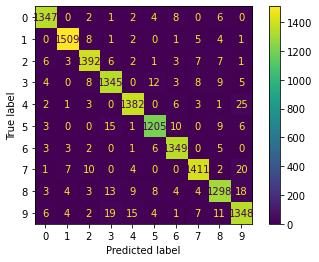

In [19]:
best_forest.confusion_matrix(save=True, file_name="random_forest_cm.png")

Analyzing feature importance

2022-12-23 01:05:34.407 | INFO     | assignment_2.digits_classifiers.utils:plot_digit:77 - Saving C:\Users\user\Documents\GitHub\AI_assignments\assignment_2\digits_classifiers\images\rf_feat_importance.png


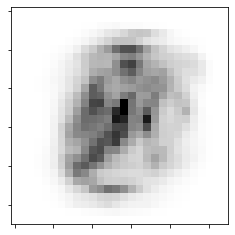

In [20]:
importance = best_forest.estimator.feature_importances_
pixels = chunks(lst=list(importance), n=28)
plot_digit(pixels=pixels, save=True, file_name='rf_feat_importance.png')

### Fool data

Behaviour on fool data

In [21]:
from assignment_2.digits_classifiers.io import read_fool_dataset

fool = read_fool_dataset()

In [22]:
best_forest.estimator.predict(X=fool)

array([4, 0, 0, 0, 5, 7])